<img src="kschool.png" width="120" height="120" align="right"/>

# Deep Learning para RecSys

<div class  = "alert alert-info">

Deep Learning tiene muchísimas aplicaciones hoy en día. En RecSys también. En este apartado, explicaremos la generación de un modelo básico basado en redes neuronales cuya funcionalidad sea la de recomendación de items y la clasificación de users/items por su cercanía en el espacio. 

**Destacamos**:
- La arquitectura de las redes neuronales destinadas a RecSys, generalmente, llevan la capa **Embeddings**.

</div>

In [ ]:

!conda install -c conda-forge keras

### Embeddings Layer

In [1]:
from keras.models import Sequential
from keras.layers import Embedding
import numpy as np

Using TensorFlow backend.


In [14]:
"""Creamos un modelo muy básico para ver cómo se generan los embeddings de forma aleatoria"""

model = Sequential()

embedding_layer = Embedding(input_dim=12,output_dim=2, input_length=1)
model.add(embedding_layer)

# input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1
# output_dim: int >= 0. Dimension of the dense embedding.

model.compile(optimizer='adam', loss='mse')

In [15]:
print(len(embedding_layer.get_weights()[0]))
embedding_layer.get_weights()

12


[array([[-0.01069353, -0.03593321],
        [ 0.01711858,  0.03937488],
        [ 0.02071525, -0.04347534],
        [ 0.03532977,  0.02441214],
        [ 0.0348999 ,  0.00450302],
        [ 0.03029199,  0.00532515],
        [ 0.02707135, -0.03912349],
        [-0.02121965,  0.01535379],
        [-0.04856913, -0.03546305],
        [ 0.01482311,  0.00654041],
        [ 0.03432706,  0.04383845],
        [ 0.02137232, -0.04390403]], dtype=float32)]

In [13]:
# print(model.predict(np.array([[4]])))

### Práctica

##### Dataset

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
def read_movie_files(folder):

    pd_ratings = pd.read_csv(folder+'/ratings.csv')
    print('Number of rating records: ' + str(len(pd_ratings)))
    print('Total of users: ' + str(pd_ratings.userId.nunique()))
    
    pd_movies = pd.read_csv(folder+'/movies.csv')
    print('Total of movies: ' + str(pd_movies.movieId.nunique()))
    
    return pd_ratings, pd_movies

folder = './data/movies'
pd_ratings, pd_movies = read_movie_files(folder)

# En este ejemplo no vamos a utilizar los géneros para nada

Number of rating records: 100836
Total of users: 610
Total of movies: 9742


In [20]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Los usuarios/películas deberían tener un ID consecutivo, por eso hacemos una transformación

pd_ratings2 = pd_ratings.copy()

pd_ratings2 = pd_ratings2.sort_values('userId').reset_index(drop=True)
pd_ratings2['user_id_new'] = 0
cnt = 1
pd_ratings2.user_id_new[0] = cnt
for i in range(1,len(pd_ratings2)):
    if pd_ratings2.userId[i] != pd_ratings2.userId[i-1]:
        cnt += 1    
    pd_ratings2.user_id_new[i] = cnt
    

pd_ratings2 = pd_ratings2.sort_values('movieId').reset_index(drop=True)
pd_ratings2['movie_id_new'] = 0
cnt = 1
pd_ratings2.movie_id_new[0] = cnt
for i in range(1,len(pd_ratings2)):
    if pd_ratings2.movieId[i] != pd_ratings2.movieId[i-1]:
        cnt += 1    
    pd_ratings2.movie_id_new[i] = cnt
        

# pd_ratings2 = pd_ratings2[['rating','user_id_new','movie_id_new']]
pd_ratings2

,userId,movieId,rating,timestamp,user_id_new,movie_id_new
0,1,1,4.0,964982703,1,1
1,112,1,3.0,1442535639,112,1
2,448,1,5.0,1019126661,448,1
3,451,1,5.0,854089165,451,1
4,453,1,5.0,1005966797,453,1
...,...,...,...,...,...,...
100831,184,193581,4.0,1537109082,184,9720
100832,184,193583,3.5,1537109545,184,9721
100833,184,193585,3.5,1537109805,184,9722
100834,184,193587,3.5,1537110021,184,9723


##### Model

In [36]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model


n_users = 610
n_movies = 9742

# Embedding Layer: An embedding column takes sparse data as input and returns a lower-dimensional dense vector as output.
# Dot Layer: Computes a dot product between samples in two tensors.

# Una primera arquitectura para transformar las peliculas
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, 50, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# Una primera arquitectura para transformar los usuarios
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 50, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Una capa para juntar ambas arquitecturas
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie-Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 50)        487150      Movie-Input[0][0]                
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        30550       User-Input[0][0]                 
____________________________________________________________________________________________

In [37]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pd_ratings2, test_size=0.2, random_state=42)

In [49]:
history = model.fit([train.user_id_new, train.movie_id_new], train.rating, epochs=10, verbose=1)

Epoch 1/10
80668/80668 [==============================] - 39s 482us/step - loss: 0.7722
Epoch 2/10
80668/80668 [==============================] - 39s 482us/step - loss: 0.6521
Epoch 3/10
80668/80668 [==============================] - 40s 491us/step - loss: 0.5549
Epoch 4/10
80668/80668 [==============================] - 40s 494us/step - loss: 0.4707
Epoch 5/10
80668/80668 [==============================] - 40s 500us/step - loss: 0.3974
Epoch 6/10
80668/80668 [==============================] - 40s 498us/step - loss: 0.3316
Epoch 7/10
80668/80668 [==============================] - 40s 492us/step - loss: 0.2752
Epoch 8/10
80668/80668 [==============================] - 37s 462us/step - loss: 0.2266
Epoch 9/10
80668/80668 [==============================] - 37s 456us/step - loss: 0.1888
Epoch 10/10
80668/80668 [==============================] - 37s 455us/step - loss: 0.1575


##### Hacemos una recomendación

In [50]:
numero_de_usuario = 2
movie_data = np.array(list(set(pd_ratings2.movie_id_new))) # todas las pelis 
user = np.array([numero_de_usuario for i in range(len(movie_data))]) 

predictions = model.predict([user, movie_data])
predictions

array([[ 3.730135  ],
       [ 4.030402  ],
       [ 3.406557  ],
       ...,
       [ 3.4627771 ],
       [ 2.6730027 ],
       [-0.07938191]], dtype=float32)

In [51]:
pd_predictions = pd.DataFrame(predictions,columns=['score'])
pd_predictions['movie_id_new'] = range(len(pd_predictions))

pd_predictions = pd.merge(pd_predictions, pd_ratings2, on='movie_id_new')
pd_predictions = pd.merge(pd_predictions, pd_movies, on='movieId')
pd_predictions = pd_predictions[['score', 'title']].drop_duplicates()
pd_predictions = pd_predictions.sort_values(by='score', ascending=False)

In [52]:
pd_predictions

,score,title
99114,6.470357,Da geht noch was! (2013)
55489,6.237610,"Big Kahuna, The (2000)"
75472,6.000915,Children of Dune (2003)
42348,5.842342,Meet Joe Black (1998)
42947,5.731104,Psycho (1998)
...,...,...
99567,-0.233367,"Big Short, The (2015)"
89535,-0.236252,Boy Eats Girl (2005)
98495,-0.239443,"Daddy, I'm A Zombie (2012)"
99329,-0.240825,Victor Frankenstein (2015)


##### Comprobamos la precisión de la red neuronal

In [53]:
y_hat = model.predict([pd_ratings2.user_id_new, pd_ratings2.movie_id_new])

In [54]:
pd_ratings2['y_hat'] = y_hat
pd_ratings2

,userId,movieId,rating,timestamp,user_id_new,movie_id_new,y_hat
0,1,1,4.0,964982703,1,1,3.702958
1,112,1,3.0,1442535639,112,1,3.445664
2,448,1,5.0,1019126661,448,1,4.561472
3,451,1,5.0,854089165,451,1,5.005678
4,453,1,5.0,1005966797,453,1,4.957592
...,...,...,...,...,...,...,...
100831,184,193581,4.0,1537109082,184,9720,4.375689
100832,184,193583,3.5,1537109545,184,9721,3.185722
100833,184,193585,3.5,1537109805,184,9722,3.725782
100834,184,193587,3.5,1537110021,184,9723,3.083560


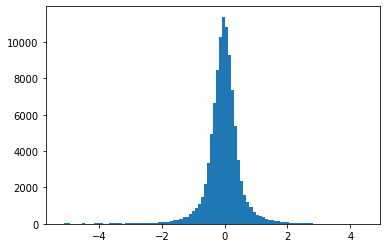

In [55]:
plt.hist(pd_ratings2.y_hat - pd_ratings2.rating, bins=100)
plt.show()

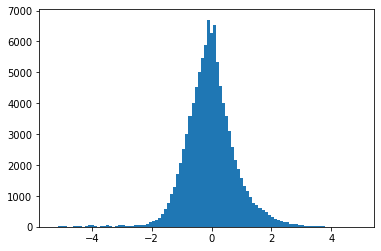

In [27]:
plt.hist(pd_ratings2.y_hat - pd_ratings2.rating, bins=100)
plt.show()

### Ejercicio:

<div class  = "alert alert-success">

Con este mismo dataset, realizar un estudio con la precisión del algoritmo cuando el espacio de embeddings aumenta. Así mismo mostrad el error cometido y el tiempo de computación.

</div>